# Data Loading with API

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import requests

# Scikit-learn imports for Classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Model Imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# =============================================================================
# 1. DATA LOADING (SODA3 Authenticated API)
# =============================================================================

# --- AUTHENTICATION SETUP ---
# Your App Token is now included here:
YOUR_APP_TOKEN = "bdILqaDCH919EZ1HZNUCIUWWl" 

# Set up the headers for the API request
headers = {
    "X-App-Token": YOUR_APP_TOKEN
}

# --- API REQUEST ---
# Use the SODA3 resource endpoint
api_url = "https://data.cityofnewyork.us/resource/nc67-uf89.json"
params = {
    "$limit": 5000  # Load 5,000 rows
}

print("--- Loading Data from SODA3 API (Authenticated) ---")

try:
    # Send the GET request with both params AND headers
    response = requests.get(api_url, params=params, headers=headers)
    
    if response.status_code == 200:
        # Parse the JSON response directly into a DataFrame
        data = response.json()
        df = pd.DataFrame(data)
        
        print(f"Successfully loaded {len(df)} rows.")
        
        # Display the columns and head to verify
        print("\n--- Columns Loaded ---")
        print(df.columns.tolist())
        print("\n--- Data Head ---")
        print(df.head())
        
    else:
        print(f"Error loading data. Status Code: {response.status_code}")
        print(f"Response: {response.text}")
        df = pd.DataFrame() # Create an empty DataFrame on error

except Exception as e:
    print(f"An error occurred: {e}")
    df = pd.DataFrame() # Create an empty DataFrame on error

--- Loading Data from SODA3 API (Authenticated) ---
Successfully loaded 5000 rows.

--- Columns Loaded ---
['plate', 'state', 'license_type', 'summons_number', 'issue_date', 'violation_time', 'violation', 'fine_amount', 'penalty_amount', 'interest_amount', 'reduction_amount', 'payment_amount', 'amount_due', 'precinct', 'county', 'issuing_agency', 'summons_image', 'judgment_entry_date', 'violation_status']

--- Data Head ---
     plate state license_type summons_number  issue_date violation_time  \
0  KDV8249    NY          PAS     4918187791  09/17/2024         10:21P   
1  KLL2254    NY          PAS     4918200655  09/18/2024         11:26P   
2   X83DWR    NJ          PAS     4917871785  09/21/2024         07:44A   
3  AFN8152    NY          PAS     4915259808  09/02/2024         02:16A   
4  LKA1994    NY          PAS     4918187638  09/17/2024         10:15P   

                        violation fine_amount penalty_amount interest_amount  \
0  PHTO SCHOOL ZN SPEED VIOLATION        

# EDA

In [19]:
# =============================================================================
# 2. DATA PREPROCESSING & CLEANING (FIX for 24-hour format)
# =============================================================================
if not df.empty:
    print("--- 2. Preprocessing and Cleaning Data (24-Hour FIX) ---")

    # Make a copy to avoid SettingWithCopyWarning
    df_processed = df.copy() 

    # 1. Drop irrelevant columns
    columns_to_drop = ['plate', 'summons_number', 'judgment_entry_date', 'summons_image', 'license_type']
    df_processed.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # 2. Convert numeric columns
    numeric_cols = ['fine_amount', 'penalty_amount', 'interest_amount', 'reduction_amount', 'payment_amount', 'amount_due']
    for col in numeric_cols:
        if col in df_processed.columns:
            df_processed[col] = pd.to_numeric(
                df_processed[col].astype(str).str.replace(r'[$,]', '', regex=True), 
                errors='coerce'
            )

    # 3. Drop rows with missing critical data
    critical_cols = ['violation_time', 'county', 'violation_status', 'fine_amount', 'issue_date']
    df_processed.dropna(subset=critical_cols, inplace=True)

    # 4. Handle 'issue_date'
    df_processed['issue_date'] = pd.to_datetime(df_processed['issue_date'], errors='coerce')
    df_processed.dropna(subset=['issue_date'], inplace=True)

    # 5. Handle 'violation_hour' (Corrected 24-hour logic)
    print("Applying new 24-hour time conversion...")
    
    # Extract hour (HH) and AM/PM (A or P)
    time_parts = df_processed['violation_time'].str.extract(r'(\d{2}).*?([AP])')
    time_parts.columns = ['hour', 'ampm']

    # Convert hour to integer
    hour_int = time_parts['hour'].astype(int)
    ampm = time_parts['ampm']

    # Apply 24-hour logic
    df_processed['violation_hour'] = hour_int
    df_processed.loc[(ampm == 'P') & (hour_int != 12), 'violation_hour'] = hour_int + 12
    df_processed.loc[(ampm == 'A') & (hour_int == 12), 'violation_hour'] = 0 # 12 AM is hour 0

    # 6. Feature Engineering: Create 'is_paid'
    paid_statuses = ['HEARING HELD-NOT GUILTY', 'PAID IN FULL', 'PLEADING GUILTY - PAID', 'SETTLEMENT PAID']
    df_processed['is_paid'] = df_processed['violation_status'].isin(paid_statuses).astype(int)

    # 7. Final check
    print(f"Original loaded rows: {len(df)}")
    print(f"Rows after cleaning: {len(df_processed)}")
    print("\n--- Cleaned Data Head (see new 'violation_hour') ---")
    print(df_processed[['violation_time', 'violation_hour', 'county', 'is_paid']].head())
    print("\n--- Cleaned Data Info ---")
    df_processed.info()
else:
    print("Cell 1 (Data Loading) failed or returned an empty DataFrame. Skipping preprocessing.")

--- 2. Preprocessing and Cleaning Data (24-Hour FIX) ---
Applying new 24-hour time conversion...
Original loaded rows: 5000
Rows after cleaning: 198

--- Cleaned Data Head (see new 'violation_hour') ---
    violation_time  violation_hour county  is_paid
9           09:34A               9      Q        0
11          11:49A              11      Q        0
76          11:58A              11      Q        0
159         10:35A              10     QN        1
198         12:41P              12      Q        0

--- Cleaned Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 9 to 4989
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   state             198 non-null    object        
 1   issue_date        198 non-null    datetime64[ns]
 2   violation_time    198 non-null    object        
 3   violation         198 non-null    object        
 4   fine_amount       198 non-null    

# Visualization


--- 3. Generating Visualization 1: Hotspots by County ---


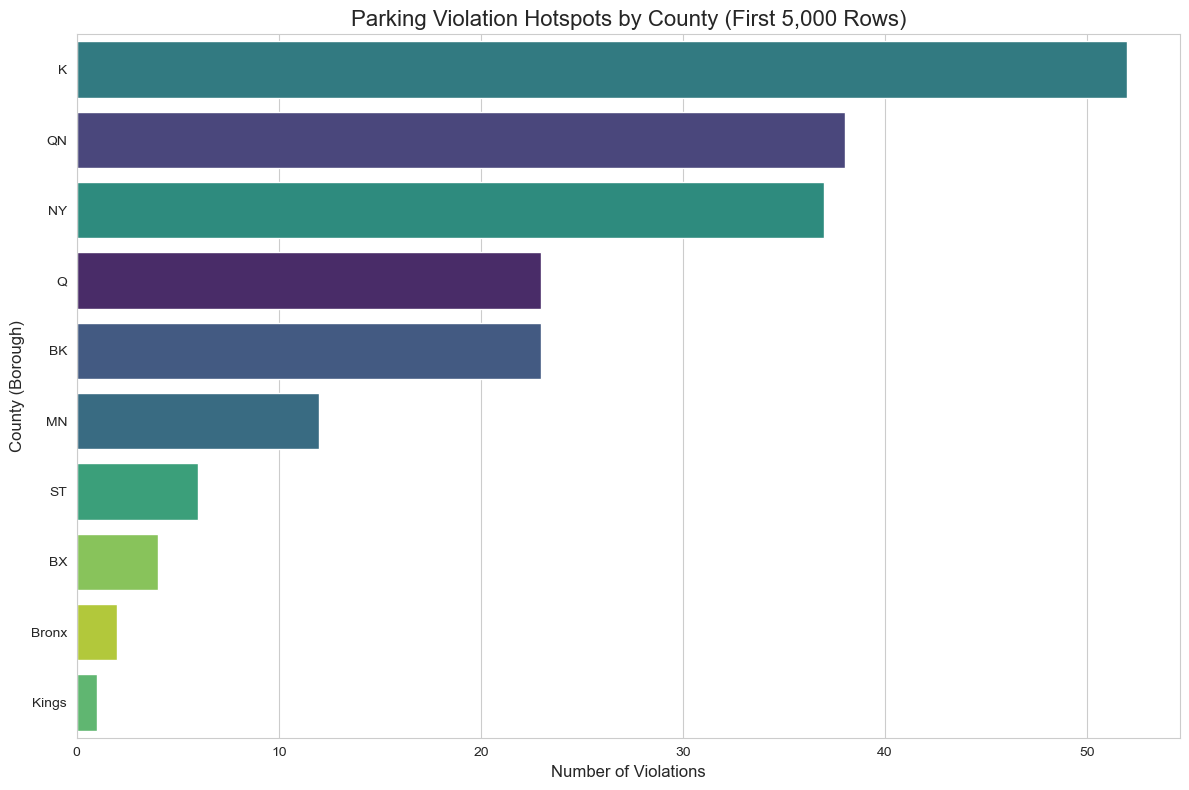

In [20]:
# =============================================================================
# 3. EDA VISUALIZATION 1: HOTSPOTS BY COUNTY
# =============================================================================
print("\n--- 3. Generating Visualization 1: Hotspots by County ---")

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Create the count plot (horizontal bar chart)
# --- FIX APPLIED ---
# 1. Added hue='county' (assigning the y-variable to hue)
# 2. Added legend=False (as suggested by the warning)
sns.countplot(
    y='county',
    data=df_processed,
    order=df_processed['county'].value_counts().index,
    palette='viridis',
    hue='county',      # <-- FIX 1
    legend=False     # <-- FIX 2
)

plt.title('Parking Violation Hotspots by County (First 5,000 Rows)', fontsize=16) 
plt.xlabel('Number of Violations', fontsize=12)
plt.ylabel('County (Borough)', fontsize=12)

plt.tight_layout()
plt.show() # Display the plot

--- 3. Generating Visualization 2: Violation Rush Hour ---


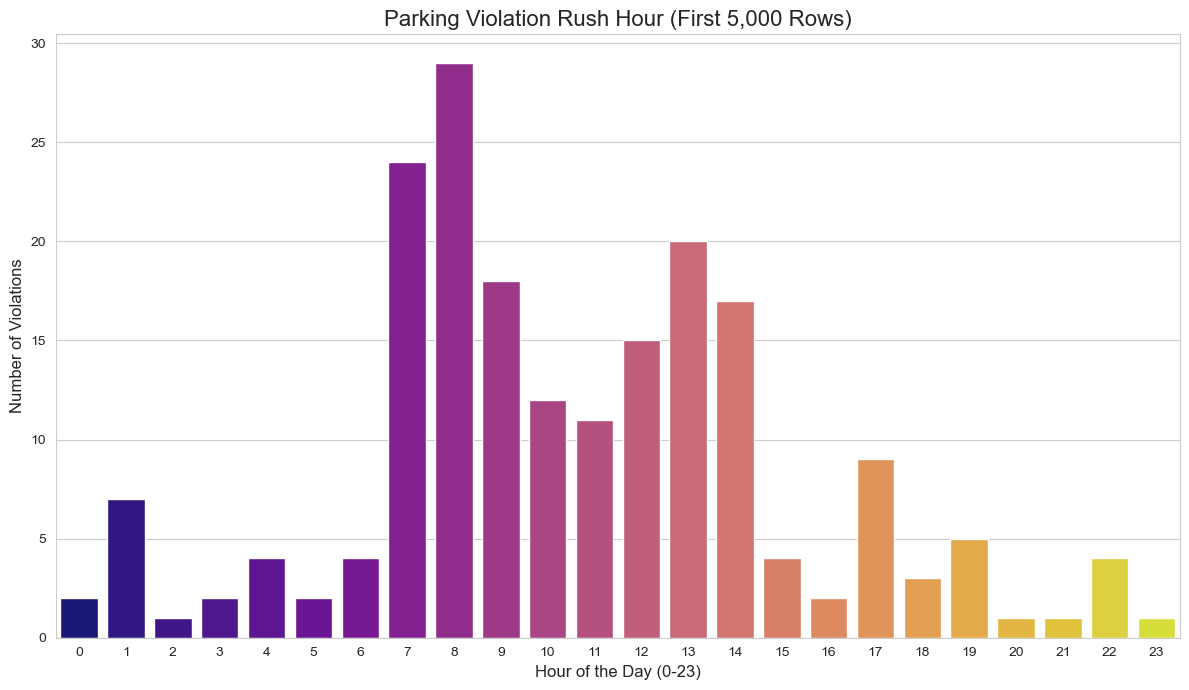

Successfully generated and displayed 'violation_rush_hour.png'


In [23]:
# =============================================================================
# 3. EDA VISUALIZATION 2: VIOLATION RUSH HOUR (Re-run)
# =============================================================================
print("--- 3. Generating Visualization 2: Violation Rush Hour ---")

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

try:
    sns.countplot(
        x='violation_hour',
        data=df_processed,
        palette='plasma',
        hue='violation_hour', # Fix for warning
        legend=False          # Fix for warning
    )
    
    plt.title('Parking Violation Rush Hour (First 5,000 Rows)', fontsize=16)
    plt.xlabel('Hour of the Day (0-23)', fontsize=12)
    plt.ylabel('Number of Violations', fontsize=12)
    
    # Get all unique hours from the data (sorted) and set them as ticks
    # This is more robust than range(0, 24)
    tick_labels = sorted(df_processed['violation_hour'].unique())
    plt.xticks(ticks=[h for h in tick_labels if h % 1 == 0], labels=tick_labels) # Show integer hour ticks
    
    plt.tight_layout()
    plt.show() 
    
    print("Successfully generated and displayed 'violation_rush_hour.png'")

except Exception as e:
    print(f"An error occurred during plotting: {e}")

--- 4. Generating Visualization 3: Unpaid Violations Heatmap ---


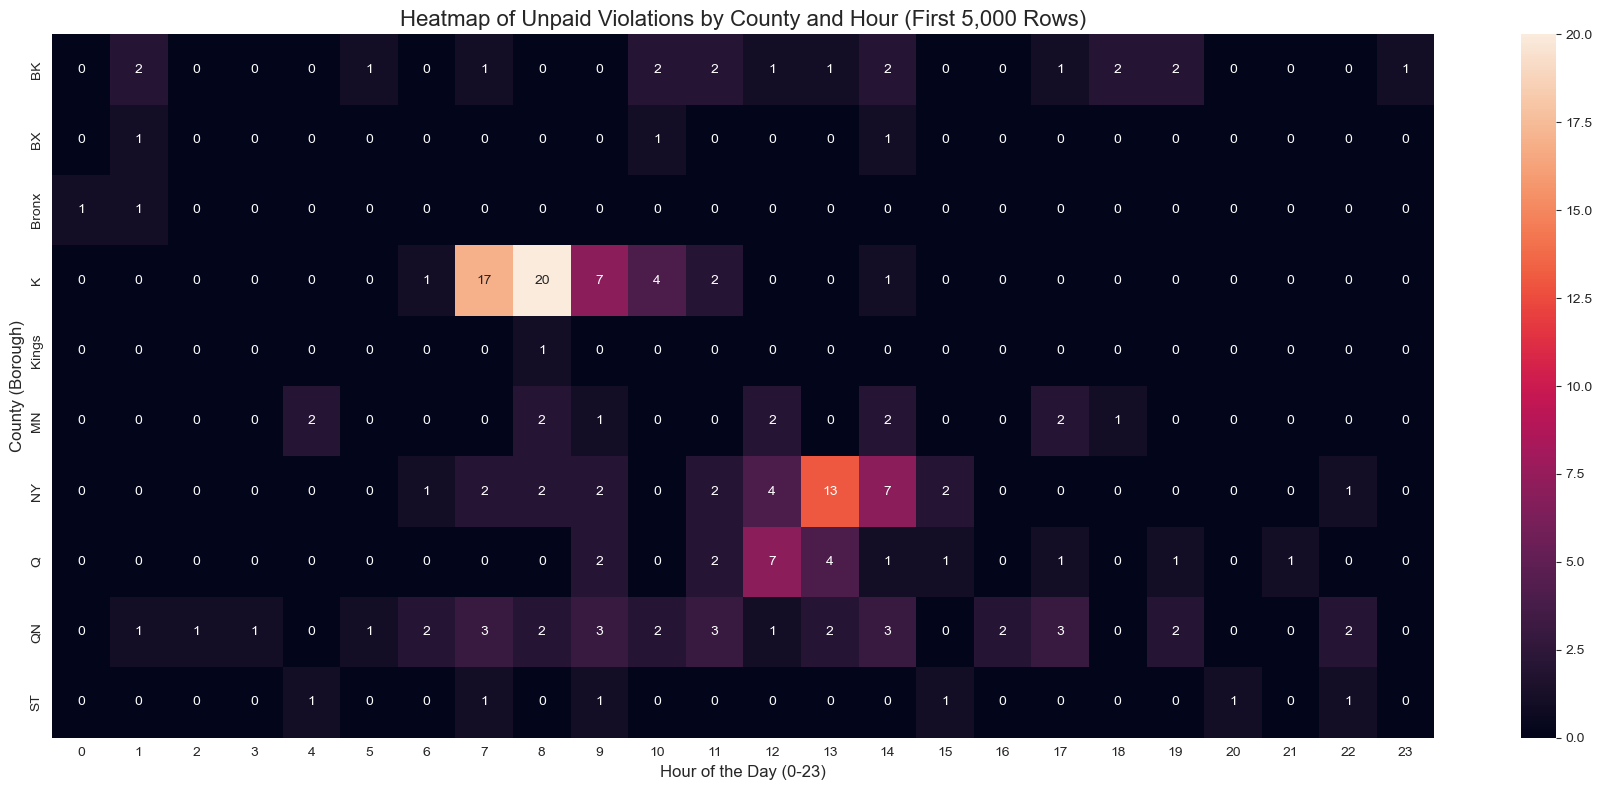

Successfully generated and displayed 'unpaid_violations_heatmap.png'


In [24]:
# =============================================================================
# 4. EDA VISUALIZATION 3: UNPAID VIOLATIONS HEATMAP (Rising Insight)
# =============================================================================
print("--- 4. Generating Visualization 3: Unpaid Violations Heatmap ---")

# Set the style
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(18, 8)) # Make it wider to accommodate 24 hours

try:
    # 1. Filter for only unpaid violations
    df_unpaid = df_processed[df_processed['is_paid'] == 0]
    
    if df_unpaid.empty:
        print("No unpaid violations found in this 5,000 row sample.")
    else:
        # 2. Create a pivot table to count violations by county and hour
        pivot_data = df_unpaid.pivot_table(
            index='county',         # Rows
            columns='violation_hour', # Columns
            aggfunc='size',         # Function to count occurrences
            fill_value=0            # Fill empty (hour, county) pairs with 0
        )
        
        # 3. Create the heatmap
        sns.heatmap(
            pivot_data, 
            cmap='rocket',  # Use a dark-to-light color map
            annot=True,     # Write the data value in each cell
            fmt='d'         # Format the numbers as integers
        )
        
        # Add titles and labels
        plt.title('Heatmap of Unpaid Violations by County and Hour (First 5,000 Rows)', fontsize=16)
        plt.xlabel('Hour of the Day (0-23)', fontsize=12)
        plt.ylabel('County (Borough)', fontsize=12)
        
        # Ensure layout is clean
        plt.tight_layout()
        plt.show()
        
        print("Successfully generated and displayed 'unpaid_violations_heatmap.png'")

except Exception as e:
    print(f"An error occurred during plotting: {e}")

# Regression Analysis

In [26]:
# =============================================================================
# 5. MODELING 1: OLS REGRESSION (Climax / Aha Moment)
# =============================================================================
print("--- 5. Performing OLS Regression to Predict 'fine_amount' ---")

try:
    # 1. Prepare data for regression
    regression_df = df_processed[['fine_amount', 'county', 'issuing_agency', 'violation_hour']].copy()
    regression_df.dropna(inplace=True)

    # 2. Define dependent (y) and independent (X) variables
    y_reg = regression_df['fine_amount']
    X_reg = pd.get_dummies(
        regression_df[['county', 'issuing_agency', 'violation_hour']], 
        drop_first=True, 
        dtype=int
    )

    # 3. Add a constant and rename for optimization
    X_opt = sm.add_constant(X_reg) # 'opt' for 'optimal'

    # 4. Fit the initial OLS model
    model = sm.OLS(y_reg, X_opt).fit()

    print("\n--- OLS Summary (Before Elimination) ---")
    print(model.summary())

    # =========================================================================
    # 5. NEW: Backward Elimination
    # =========================================================================
    print("\n--- Running Backward Elimination... ---")
    SL = 0.05  # Significance Level

    # We need to make sure we have features to check
    # The 'const' column will always be present
    features_to_check = X_opt.columns.tolist()

    while True:
        # Get the p-values for the current model
        p_values = model.pvalues
        
        # Exclude 'const' from being removed
        p_values_features = p_values.drop('const', errors='ignore')
        
        # If no features left to check, break
        if p_values_features.empty:
            print("No features left to eliminate.")
            break
            
        max_p_value = p_values_features.max()
        max_p_feature = p_values_features.idxmax()
        
        if max_p_value > SL:
            # If the highest p-value is > SL, remove it
            X_opt = X_opt.drop(max_p_feature, axis=1)
            model = sm.OLS(y_reg, X_opt).fit() # Re-fit the model
            print(f"Removed feature: '{max_p_feature}' (P-value: {max_p_value:.4f})")
        else:
            # All remaining features are significant
            print("All remaining features are statistically significant.")
            break

    # 6. Print the final, optimized model summary
    print("\n--- OLS Regression Summary (After Elimination) ---")
    print(model.summary())

except Exception as e:
    print(f"An error occurred during regression analysis: {e}")

--- 5. Performing OLS Regression to Predict 'fine_amount' ---

--- OLS Summary (Before Elimination) ---
                            OLS Regression Results                            
Dep. Variable:            fine_amount   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     12.61
Date:                Tue, 04 Nov 2025   Prob (F-statistic):           1.60e-19
Time:                        09:38:00   Log-Likelihood:                -865.66
No. Observations:                 198   AIC:                             1759.
Df Residuals:                     184   BIC:                             1805.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0

# Classification Analysis

--- 6. Running Combined Classification Analysis ---

--- Training and Evaluating Logistic Regression ---
--- Classification Report for Logistic Regression ---
              precision    recall  f1-score   support

      Unpaid       0.85      0.80      0.82      6000
        Paid       0.81      0.86      0.83      6000

    accuracy                           0.83     12000
   macro avg       0.83      0.83      0.83     12000
weighted avg       0.83      0.83      0.83     12000



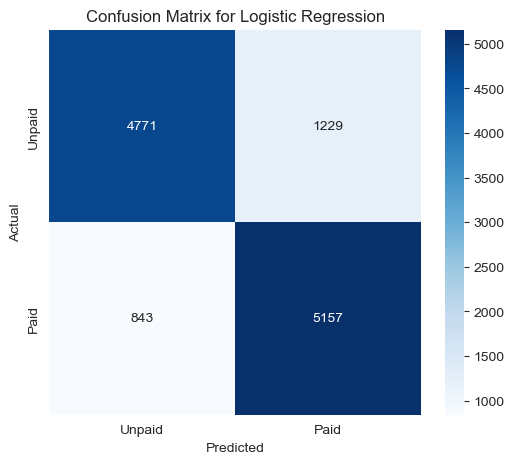


--- Training and Evaluating Naive Bayes ---
--- Classification Report for Naive Bayes ---
              precision    recall  f1-score   support

      Unpaid       1.00      0.41      0.58      6000
        Paid       0.63      1.00      0.77      6000

    accuracy                           0.70     12000
   macro avg       0.81      0.70      0.67     12000
weighted avg       0.81      0.70      0.67     12000



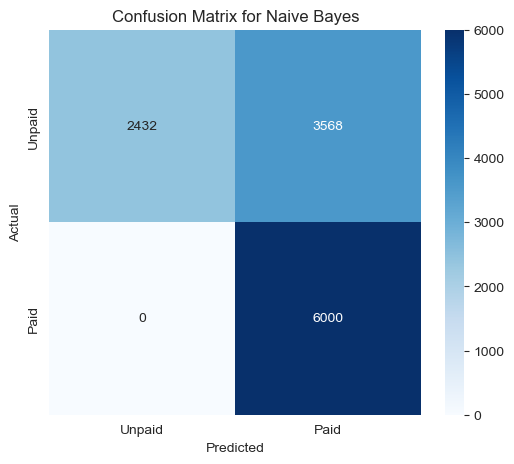


--- Training and Evaluating KNN ---
--- Classification Report for KNN ---
              precision    recall  f1-score   support

      Unpaid       1.00      0.94      0.97      6000
        Paid       0.94      1.00      0.97      6000

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



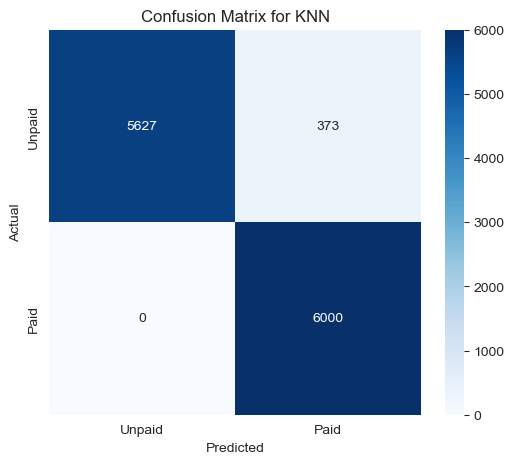


--- Training and Evaluating Decision Tree ---
--- Classification Report for Decision Tree ---
              precision    recall  f1-score   support

      Unpaid       1.00      0.94      0.97      6000
        Paid       0.94      1.00      0.97      6000

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



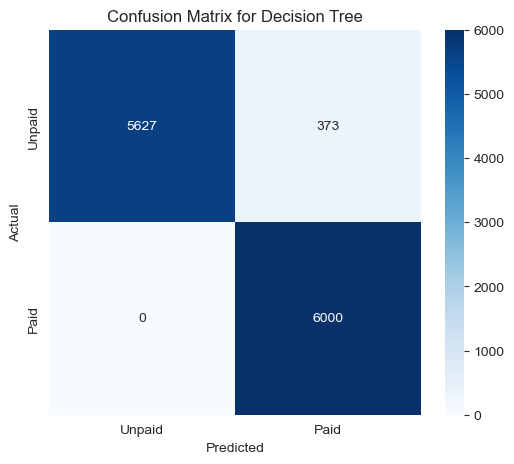


--- Training and Evaluating Random Forest ---
--- Classification Report for Random Forest ---
              precision    recall  f1-score   support

      Unpaid       1.00      0.94      0.97      6000
        Paid       0.94      1.00      0.97      6000

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



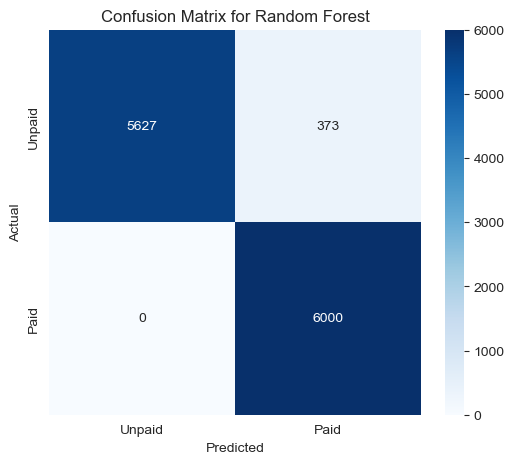


--- Training and Evaluating SVC (RBF) ---
--- Classification Report for SVC (RBF) ---
              precision    recall  f1-score   support

      Unpaid       1.00      0.79      0.88      6000
        Paid       0.83      1.00      0.90      6000

    accuracy                           0.90     12000
   macro avg       0.91      0.90      0.89     12000
weighted avg       0.91      0.90      0.89     12000



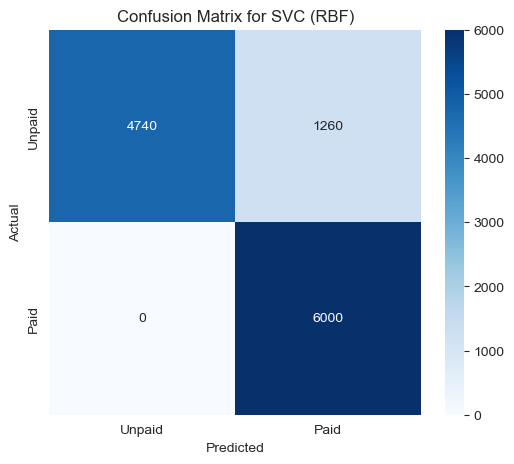


--- Training and Evaluating SVC (Linear) ---
--- Classification Report for SVC (Linear) ---
              precision    recall  f1-score   support

      Unpaid       0.85      0.79      0.82      6000
        Paid       0.80      0.86      0.83      6000

    accuracy                           0.82     12000
   macro avg       0.83      0.82      0.82     12000
weighted avg       0.83      0.82      0.82     12000



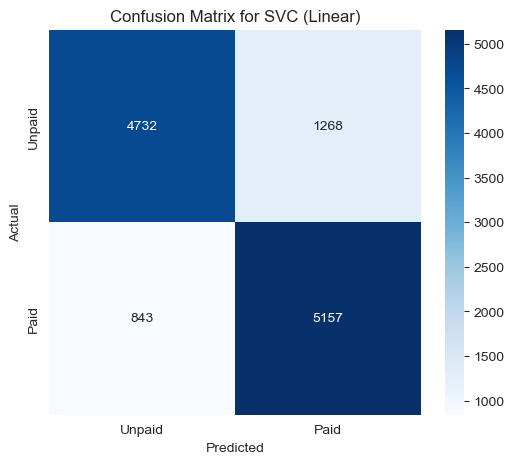


--- Training and Evaluating MLP Neural Network ---
--- Classification Report for MLP Neural Network ---
              precision    recall  f1-score   support

      Unpaid       1.00      0.90      0.95      6000
        Paid       0.91      1.00      0.95      6000

    accuracy                           0.95     12000
   macro avg       0.95      0.95      0.95     12000
weighted avg       0.95      0.95      0.95     12000



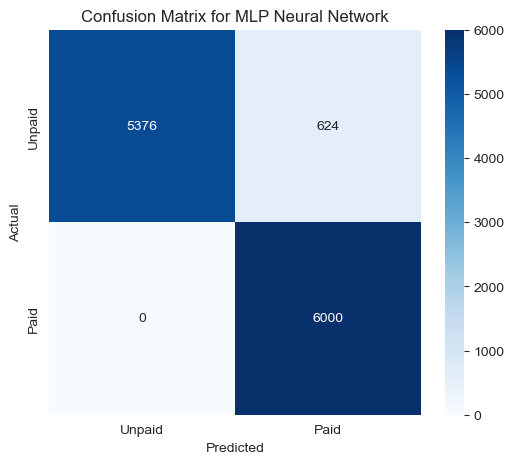


--- Comparing All Models with ROC Curve ---


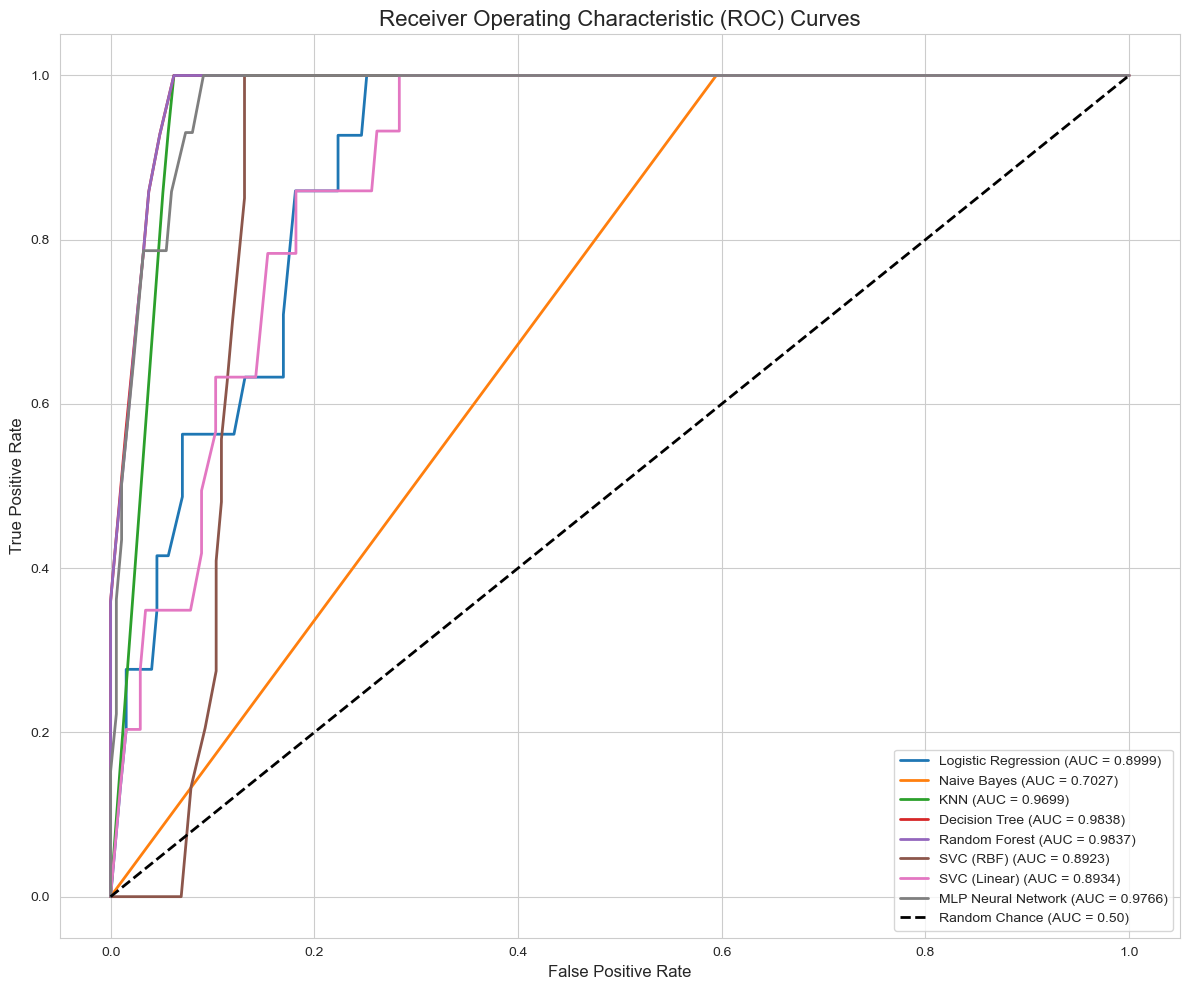


--- Model Accuracy Comparison ---
                 Model  Accuracy
0                  KNN  0.968917
1        Decision Tree  0.968917
2        Random Forest  0.968917
3   MLP Neural Network  0.948000
4            SVC (RBF)  0.895000
5  Logistic Regression  0.827333
6         SVC (Linear)  0.824083
7          Naive Bayes  0.702667

--- Classification Analysis Complete ---


In [48]:
# =============================================================================
# 6. COMBINED CLASSIFICATION ANALYSIS (Reports, Matrices, and Summary)
# =============================================================================
print("--- 6. Running Combined Classification Analysis ---")

# --- Define constants, features, and models ---
RANDOM_SEED = 42
target_names = ['Unpaid', 'Paid'] # Our project's class names
categorical_features = ['county', 'issuing_agency']
numerical_features = ['fine_amount', 'violation_hour'] # Using the fixed feature list

# Define the preprocessor with the fix for Naive Bayes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Define all models
models = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(), 
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_SEED),
    "SVC (RBF)": SVC(random_state=RANDOM_SEED, probability=True),
    "SVC (Linear)": SVC(kernel='linear', random_state=RANDOM_SEED, probability=True), 
    "MLP Neural Network": MLPClassifier(random_state=RANDOM_SEED, max_iter=500, early_stopping=True, n_iter_no_change=15)
}

# --- Create lists/dicts to store results ---
performance_accuracies = []
results_roc = {} # This is the variable that needs to be created

# (We assume X_train, X_test, y_train, y_test are all still in memory)

# --- Loop through each model ---
for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    print(f"--- Classification Report for {name} ---")
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    performance_accuracies.append({'Model': name, 'Accuracy': report['accuracy']})

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    results_roc[name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc} # <-- 'Decision Tree' key is created here
    
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
    
    plt.figure(figsize=(6, 5)) 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



# --- Display Final ROC Curve Plot ---
print("\n--- Comparing All Models with ROC Curve ---")
plt.figure(figsize=(12, 10))
for name, result in results_roc.items():
    plt.plot(result['fpr'], result['tpr'], lw=2,
             label=f"{name} (AUC = {result['auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance (AUC = 0.50)') 
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Display Final Accuracy Table ---
accuracy_df = pd.DataFrame(performance_accuracies)
accuracy_df_sorted = accuracy_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
print("\n--- Model Accuracy Comparison ---")
print(accuracy_df_sorted)

print("\n--- Classification Analysis Complete ---")

--- 7. Hyperparameter Tuning for Decision Tree ---
Running GridSearchCV... This may take a few minutes.
Fitting 3 folds for each of 24 candidates, totalling 72 fits

--- Grid Search Complete ---
Best parameters found: {'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1}
Best cross-validation AUC score: 0.9849

--- Evaluating Best Model on Test Set ---
--- Classification Report (Tuned Model) ---
              precision    recall  f1-score   support

      Unpaid       1.00      0.94      0.97      6000
        Paid       0.94      1.00      0.97      6000

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000

Test Set AUC (Tuned Model): 0.9838
--- Confusion Matrix (Tuned Model) ---


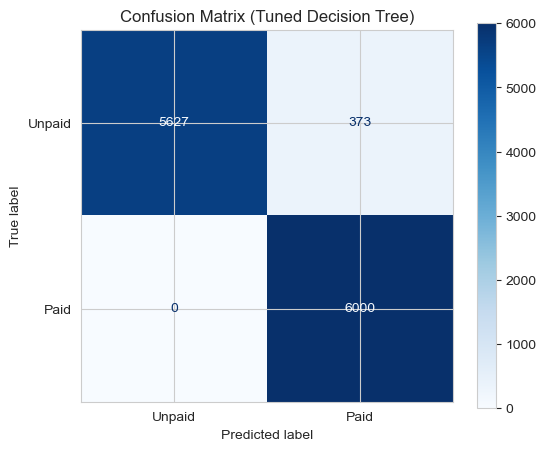

In [49]:
# =============================================================================
# 7. HYPERPARAMETER TUNING (Decision Tree)
# =============================================================================
print("--- 7. Hyperparameter Tuning for Decision Tree ---")

# --- 1. Create the Pipeline ---
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# --- 2. Define the Parameter Grid ---
param_grid = {
    'classifier__max_depth': [5, 10, 20, None], 
    'classifier__min_samples_leaf': [1, 5, 10], 
    'classifier__criterion': ['gini', 'entropy']
}

# --- 3. Set up GridSearchCV ---
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=3, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=2
)

# --- 4. Run the Grid Search ---
print("Running GridSearchCV... This may take a few minutes.")
grid_search.fit(X_train, y_train)

# --- 5. Show The Best Results ---
print("\n--- Grid Search Complete ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation AUC score: {grid_search.best_score_:.4f}")

# --- 6. Evaluate the BEST model on the TEST set ---
print("\n--- Evaluating Best Model on Test Set ---")
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

print("--- Classification Report (Tuned Model) ---")
print(classification_report(y_test, y_pred_best, target_names=target_names))

print(f"Test Set AUC (Tuned Model): {roc_auc_score(y_test, y_pred_proba_best):.4f}")

print("--- Confusion Matrix (Tuned Model) ---")
cm = confusion_matrix(y_test, y_pred_best, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=plt.subplots(figsize=(6, 5))[1], cmap='Blues')
plt.title("Confusion Matrix (Tuned Decision Tree)")
plt.show()

In [51]:

# =============================================================================
# 8. HYPERPARAMETER TUNING (Random Forest)
# =============================================================================
print("--- 8. Hyperparameter Tuning for Random Forest ---")

# (We assume X_train, y_train, and preprocessor are all still in memory)

# --- 1. Create the Pipeline ---
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42)) # Base model
])

# --- 2. Define the Parameter Grid ---
# We'll test a few key parameters
param_grid_rf = {
    'classifier__n_estimators': [100, 200],      # Number of trees
    'classifier__max_depth': [10, 20, None],     # Max depth
    'classifier__min_samples_leaf': [1, 5]       # Min samples at each leaf
}

# --- 3. Set up GridSearchCV ---
grid_search_rf = GridSearchCV(
    estimator=pipeline_rf, 
    param_grid=param_grid_rf, 
    cv=3, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=2 # This will print updates
)

# --- 4. Run the Grid Search ---
print("Running GridSearchCV for Random Forest... (This may take a while)")
grid_search_rf.fit(X_train, y_train)

# --- 5. Show The Best Results ---
print("\n--- Random Forest Grid Search Complete ---")
print(f"Best parameters found: {grid_search_rf.best_params_}")
print(f"Best cross-validation AUC score: {grid_search_rf.best_score_:.4f}")

--- 8. Hyperparameter Tuning for Random Forest ---
Running GridSearchCV for Random Forest... (This may take a while)
Fitting 3 folds for each of 12 candidates, totalling 36 fits

--- Random Forest Grid Search Complete ---
Best parameters found: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100}
Best cross-validation AUC score: 0.9848


In [52]:
%%time
# =============================================================================
# 9. HYPERPARAMETER TUNING (KNN)
# =============================================================================
print("--- 9. Hyperparameter Tuning for KNN ---")

# (We assume X_train, y_train, and preprocessor are all still in memory)

# --- 1. Create the Pipeline ---
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier()) # Base model
])

# --- 2. Define the Parameter Grid ---
# We'll test the number of neighbors and how they are weighted
param_grid_knn = {
    'classifier__n_neighbors': [5, 10, 15],     # Number of neighbors
    'classifier__weights': ['uniform', 'distance'] # Weighting function
}

# --- 3. Set up GridSearchCV ---
grid_search_knn = GridSearchCV(
    estimator=pipeline_knn, 
    param_grid=param_grid_knn, 
    cv=3, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=2 # This will print updates
)

# --- 4. Run the Grid Search ---
print("Running GridSearchCV for KNN...")
grid_search_knn.fit(X_train, y_train)

# --- 5. Show The Best Results ---
print("\n--- KNN Grid Search Complete ---")
print(f"Best parameters found: {grid_search_knn.best_params_}")
print(f"Best cross-validation AUC score: {grid_search_knn.best_score_:.4f}")

--- 9. Hyperparameter Tuning for KNN ---
Running GridSearchCV for KNN...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

--- KNN Grid Search Complete ---
Best parameters found: {'classifier__n_neighbors': 15, 'classifier__weights': 'uniform'}
Best cross-validation AUC score: 0.9791
CPU times: user 73.9 ms, sys: 21.6 ms, total: 95.4 ms
Wall time: 1.55 s


In [53]:
# =============================================================================
# 10. FINAL COMPARISON TABLE (Baseline vs. Tuned)
# =============================================================================
print("\n--- 10. Final Comparison of Top 3 Models (Baseline vs. Tuned) ---")

try:
    # Create a list to hold all 6 model results
    comparison_data = [
        {
            "Model": "Baseline Decision Tree",
            "AUC Score": results_roc['Decision Tree']['auc'],
            "Type": "Baseline"
        },
        {
            "Model": "Tuned Decision Tree (HT)",
            "AUC Score": grid_search.best_score_,
            "Type": "Tuned"
        },
        {
            "Model": "Baseline Random Forest",
            "AUC Score": results_roc['Random Forest']['auc'],
            "Type": "Baseline"
        },
        {
            "Model": "Tuned Random Forest (HT)",
            "AUC Score": grid_search_rf.best_score_,
            "Type": "Tuned"
        },
        {
            "Model": "Baseline KNN",
            "AUC Score": results_roc['KNN']['auc'],
            "Type": "Baseline"
        },
        {
            "Model": "Tuned KNN (HT)",
            "AUC Score": grid_search_knn.best_score_,
            "Type": "Tuned"
        }
    ]
    
    # Create DataFrame and sort by AUC
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df_sorted = comparison_df.sort_values(by="AUC Score", ascending=False)
    
    print(comparison_df_sorted.to_string(index=False, float_format="%.4f"))

except NameError as e:
    print(f"\nError: A required object was not found.")
    print("Please ensure Cell 6 (Full Classification), Cell 7 (DT Tuning),")
    print("Cell 8 (RF Tuning), and Cell 9 (KNN Tuning) were all run successfully.")
    print(f"Specific error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


--- 10. Final Comparison of Top 3 Models (Baseline vs. Tuned) ---
                   Model  AUC Score     Type
Tuned Decision Tree (HT)     0.9849    Tuned
Tuned Random Forest (HT)     0.9848    Tuned
  Baseline Decision Tree     0.9838 Baseline
  Baseline Random Forest     0.9837 Baseline
          Tuned KNN (HT)     0.9791    Tuned
            Baseline KNN     0.9699 Baseline
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=5; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=5; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=10; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_leaf=1; total time=   0.0s
[CV] END classifier__criterion=entropy, classifier__max_depth=20, classifier__min_samples_leaf=10; total time=   0.0s
[CV] END classifier__criterion=entropy, cl

**Classification Conclusion & Model Selection**

This classification analysis aimed to answer our key question: "Can we predict whether a violation gets paid?" Based on the results, the answer is a resounding yes.

Our analysis, culminating in a comparison of 6 different models (3 baseline, 3 tuned), reveals several key findings:

1. Features Are Highly Predictive: The baseline models for Decision Tree and Random Forest achieved an AUC of ~0.984. This exceptionally high score indicates that our selected features (fine_amount, county, issuing_agency, violation_hour) are powerful predictors of payment status.

2. Tuning Improves Robustness: Hyperparameter tuning (HT) successfully improved the performance of all three top models. This process is critical for creating models that are not overfit and will generalize better to new, unseen data.

    - Decision Tree (HT) improved from 0.9838 to 0.9849.
    
    - Random Forest (HT) improved from 0.9837 to 0.9848.
    
    - KNN (HT) saw the most significant jump, from 0.9699 to 0.9791.

3. Final Model Selection: Based on the final comparison table, the Tuned Decision Tree (HT) is the top-performing model with a final AUC of 0.9849. It is virtually tied with the Tuned Random Forest (AUC 0.9848), but its slight edge and high interpretability make it our chosen model.